# Day 5 Morning - Genomics Application

### Objective: Perform bioinformatic analysis of DNA sequencing data using command-line tools

Exome sequencing is a wet lab technique that enriches just for the exomes of the genome. In humans, this is only about 30Mbp, a small fraction (1%) of the total genome size (~3Gb). The advantage is the cost and time savings of looking at a smaller portion of the genome.

For this test, we are going to analyze the exome of a family where the male child is affected by osteopetrosis (https://ghr.nlm.nih.gov/condition/osteopetrosis). The parents (though consanguineous (related)) do not suffer from this disorder, suggesting it is passed as a recessive genotype. There are different genetically inherited types of osteopetrosis - we need to identify what type and what gene variants are causing.

Sequencing a family that has a child with a rare and autosomally recessive disease, you will use DNA sequencing to identify where the mutations are in their genome. We hav4We will use sequencing data from a family to identify potentially disease-associated mutations.

(stealing idea from https://training.galaxyproject.org/training-material/topics/variant-analysis/tutorials/exome-seq/tutorial.html#post-processing-freebayes-calls)

### Step 1: Set up the environment

First - we are going to use mamba to install bioinformatic tools.  Lots of bioinformatic tools are available via mamba/conda, not just python packages.  This makes things really easy to install. 

In [2]:
!mamba install -c bioconda fastqc multiqc bwa samtools bcftools freebayes=1.3.6 -y


Looking for: ['fastqc', 'multiqc', 'bwa', 'samtools', 'bcftools', 'freebayes=1.3.6']

[+] 0.0s
bioconda/linux-64 (check zst) ━━━━━━━━━━━╸━━━   0.0 B @  ??.?MB/s Checking  0.0sbioconda/linux-64 (check zst)                       Checked  0.1s
[+] 0.0s
bioconda/noarch (check zst) ━━━━━━━━━╸━━━━━━━   0.0 B @  ??.?MB/s Checking  0.0sbioconda/noarch (check zst)                         Checked  0.0s
[+] 0.0s
bioconda/linux-64 ━━━━━━━━━━━╸━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.0s[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━━╸━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
conda-forge/noarch   ━━━━━━━━╸━━━━━━━━━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s
bioconda/linux-64    ╸━━━━━━━━━━━━━━━━━━━━━━ 407.9kB /   4.6MB @   7.4MB/s  0.1s
bioconda/noarch      ╸━━━━━━━━━━━━━━━╸━━━━━━   0.0 B /  ??.?MB @  ??.?MB/s  0.1s[+] 0.2s
conda-forge/linux-64 ━━━━━━━━━━━━━━━━━━━━━━━   1.2MB /  37.4MB @  11.4MB/s  0.2s
conda-forge/noarch   ━━╸━━━━━━━━━━━━━━━━━━━━   2.3MB /  16.2MB @  21.9MB/s  0.2s
bioconda/li

## Step 2: Load the raw sequencing data

Going to setup a working directory for our data files.  Using "Python magic" we can run shell commands in the notebook.  This is a great way to interact with the command line tools we will be using.

Python magic has two main aspects - first is the ! command which runs a shell command.  The second is the % command which runs a magic command.  We will use both in this notebook.

In [1]:
#create a working directory, then change to it for the rest of the cells
!mkdir -p ~/working 
%cd ~/working 

/home/timp/working


In [2]:
# Download raw FASTQ files from Zenodo

!wget https://zenodo.org/record/3243160/files/father_R1.fq.gz
!wget https://zenodo.org/record/3243160/files/father_R2.fq.gz
!wget https://zenodo.org/record/3243160/files/mother_R1.fq.gz
!wget https://zenodo.org/record/3243160/files/mother_R2.fq.gz
!wget https://zenodo.org/record/3243160/files/proband_R1.fq.gz
!wget https://zenodo.org/record/3243160/files/proband_R2.fq.gz


--2024-08-30 02:03:21--  https://zenodo.org/record/3243160/files/father_R1.fq.gz
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/3243160/files/father_R1.fq.gz [following]
--2024-08-30 02:03:22--  https://zenodo.org/records/3243160/files/father_R1.fq.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 150814720 (144M) [application/octet-stream]
Saving to: ‘father_R1.fq.gz’

father_R1.fq.gz     100%[===================>] 143.83M  37.8MB/s    in 4.3s    

2024-08-30 02:03:26 (33.1 MB/s) - ‘father_R1.fq.gz’ saved [150814720/150814720]

--2024-08-30 02:03:26--  https://zenodo.org/record/3243160/files/father_R2.fq.gz
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.

Steps to download the reference genome and index it - we are going to use the human reference genome hg19.  This is an older version - but frankly I know it works for this data because I've used this exercise before.  We then have to tell the sequence aligner to "index" the reference - this assembles a file from the full reference sequence that allows the aligner to quickly place the reads correctly. 

The data is large and the indexing takes a while, so we have already done this for you.

In [ ]:
#!wget http://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/hg19.fa.gz
#!gunzip hg19.fa.gz
#!bwa index hg19.fa


## Step 3: Quality Control

In [ ]:
Using a tool called FASTQC we are going to check the quality of the raw FASTQ files.

Fastq data is a text file that looks like this:

@SEQ_ID
GATTTGGGGTTCAAAGCAGTATCGATCAAATAGTAAATCCATTTGTTCAACTCACAGTTT
+
!''*((((***+))%%%++)(%%%%).1***-+*''))**55CCF>>>>>>CCCCCCC65

The first line is a “@” followed by an identifier “Seq_ID”
The second line is a sequence of DNA (ACGT)
The third line is a “+” optionally followed by the same identifier
The fourth line is the quality of the DNA sequence – how sure you are that it is right.

The quality score is given by the sequencing instrument, should be used as a guide. “PHRED” Quality score is given by -10 log10 (Probability base is wrong) It’s encoded as a single letter, using an ASCII scheme (ascii value – 33)


In [3]:
# Run FastQC to evaluate the quality of the raw data
!fastqc father_R1.fq.gz father_R2.fq.gz mother_R1.fq.gz mother_R2.fq.gz proband_R1.fq.gz proband_R2.fq.gz -o .

application/gzip
application/gzip
Started analysis of father_R1.fq.gz
application/gzip
application/gzip
application/gzip
application/gzip
Approx 5% complete for father_R1.fq.gz
Approx 10% complete for father_R1.fq.gz
Approx 15% complete for father_R1.fq.gz
Approx 20% complete for father_R1.fq.gz
Approx 25% complete for father_R1.fq.gz
Approx 30% complete for father_R1.fq.gz
Approx 35% complete for father_R1.fq.gz
Approx 40% complete for father_R1.fq.gz
Approx 45% complete for father_R1.fq.gz
Approx 50% complete for father_R1.fq.gz
Approx 55% complete for father_R1.fq.gz
Approx 60% complete for father_R1.fq.gz
Approx 65% complete for father_R1.fq.gz
Approx 70% complete for father_R1.fq.gz
Approx 75% complete for father_R1.fq.gz
Approx 80% complete for father_R1.fq.gz
Approx 85% complete for father_R1.fq.gz
Approx 90% complete for father_R1.fq.gz
Approx 95% complete for father_R1.fq.gz
Analysis complete for father_R1.fq.gz
Started analysis of father_R2.fq.gz
Approx 5% complete for father

In [4]:
# Aggregate FastQC results using MultiQC
!multiqc .


/// ]8;id=953050;https://multiqc.info\MultiQC]8;;\ 🔍 v1.24.1

       file_search | Search path: /home/timp/working
         searching | ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 18/18  18  
            fastqc | Found 6 reports
     write_results | Data        : multiqc_data
     write_results | Report      : multiqc_report.html
           multiqc | MultiQC complete


## Step 4: Alignment

Next we are going to align the FASTQ files - using the index we already generated for the hg19 human reference.

This will generate a Sequence Alignment/Map SAM/BAM file:
The specification for this format is here (https://samtools.github.io/hts-specs/SAMv1.pdf)
It’s a TAB-delimited file with 11 “mandatory” columns, and some other options ones. BAM (Binary Alignment/Map Format) is the same as a SAM, except not in raw text, instead binary compress which takes up less hard drive space.
Samtools can be used to manipulate these files, as can pysam (python) and other packages in different languages. Best simple tool for looking at SAM/BAM files: IGV (http://software.broadinstitute.org/software/igv/)


In [5]:
!bwa mem -R '@RG\tID:000\tSM:father' /home/kwoyshn1/hg19_reference_genome/hg19.fa father_R1.fq.gz father_R2.fq.gz > father.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 99010 sequences (10000010 bp)...
[M::process] read 99010 sequences (10000010 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (9, 41827, 0, 1)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (237, 253, 268)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (175, 330)
[M::mem_pestat] mean and std.dev: (252.58, 23.05)
[M::mem_pestat] low and high boundaries for proper pairs: (144, 361)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 99010 reads in 5.784 CPU sec, 5.651 real sec
[M::process] read 99010 sequences (10000010 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 16286, 0, 3)
[M::mem_pestat] skip orientation 

In [6]:
!bwa mem -R '@RG\tID:001\tSM:mother' /home/kwoyshn1/hg19_reference_genome/hg19.fa mother_R1.fq.gz mother_R2.fq.gz > mother.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 99010 sequences (10000010 bp)...
[M::process] read 99010 sequences (10000010 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 42316, 0, 4)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (222, 241, 262)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (142, 342)
[M::mem_pestat] mean and std.dev: (241.81, 27.41)
[M::mem_pestat] low and high boundaries for proper pairs: (102, 382)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 99010 reads in 6.623 CPU sec, 6.489 real sec
[M::process] read 99010 sequences (10000010 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 19070, 0, 6)
[M::mem_pestat] skip orientation 

In [7]:
!bwa mem -R '@RG\tID:002\tSM:proband' /home/kwoyshn1/hg19_reference_genome/hg19.fa proband_R1.fq.gz proband_R2.fq.gz > proband.sam

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 99010 sequences (10000010 bp)...
[M::process] read 99010 sequences (10000010 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (1, 38370, 0, 2)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (254, 273, 292)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (178, 368)
[M::mem_pestat] mean and std.dev: (272.85, 26.53)
[M::mem_pestat] low and high boundaries for proper pairs: (140, 406)
[M::mem_pestat] skip orientation RF as there are not enough pairs
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_process_seqs] Processed 99010 reads in 6.465 CPU sec, 6.331 real sec
[M::process] read 99010 sequences (10000010 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (0, 31755, 0, 0)
[M::mem_pestat] skip orientation 

In [2]:
# Convert SAM to BAM and sort BAM files
!samtools sort father.sam -o father.bam
!samtools sort mother.sam -o mother.bam
!samtools sort proband.sam -o proband.bam

[bam_sort_core] merging from 1 files and 1 in-memory blocks...
[bam_sort_core] merging from 1 files and 1 in-memory blocks...
[W::sam_read1_sam] Parse error at line 2190193
samtools sort: truncated file. Aborting


## Step 5: Filter Alignments

We will filter out any reads that don't have correct pairings, are not mapped, or are duplicates.  This is a common step in bioinformatics analysis - we want to make sure we are only looking at high quality data.

Because we performed PCR during sequencing, we need to mark duplicates in the BAM files. This is because PCR duplicates can lead to false positive variant calls. Samtools can be used to mark duplicates.

In [3]:
!samtools view -b -f 2 father.bam > father.filtered.bam
!samtools view -b -f 2 mother.bam > mother.filtered.bam
!samtools view -b -f 2 proband.bam > proband.filtered.bam

In [4]:
!samtools rmdup father.filtered.bam father.filtered.rmdup.bam
!samtools rmdup mother.filtered.bam mother.filtered.rmdup.bam
!samtools rmdup proband.filtered.bam proband.filtered.rmdup.bam

[bam_rmdup_core] processing reference chr1...
[bam_rmdup_core] processing reference chr2...
[bam_rmdup_core] processing reference chr3...
[bam_rmdup_core] processing reference chr4...
[bam_rmdup_core] processing reference chr5...
[bam_rmdup_core] processing reference chr6...
[bam_rmdup_core] processing reference chr7...
[bam_rmdup_core] processing reference chrX...
[bam_rmdup_core] processing reference chr8...
[bam_rmdup_core] inconsistent BAM file for pair 'DCW97JN1:309:C0C42ACXX:4:2111:14661:52488'. Continue anyway.
[bam_rmdup_core] inconsistent BAM file for pair 'DCW97JN1:309:C0C42ACXX:5:2308:15753:39479'. Continue anyway.
[bam_rmdup_core] inconsistent BAM file for pair 'DCW97JN1:309:C0C42ACXX:5:2305:17385:94230'. Continue anyway.
[bam_rmdup_core] inconsistent BAM file for pair 'DCW97JN1:309:C0C42ACXX:4:2204:15898:63989'. Continue anyway.
[bam_rmdup_core] inconsistent BAM file for pair 'DCW97JN1:309:C0C42ACXX:4:2302:9590:59579'. Continue anyway.
[bam_rmdup_core] inconsistent BAM fil

## Step 6: Variant Calling

Next we have to look for differences in our samples (father, mother, proband) as compared to the reference genome.  

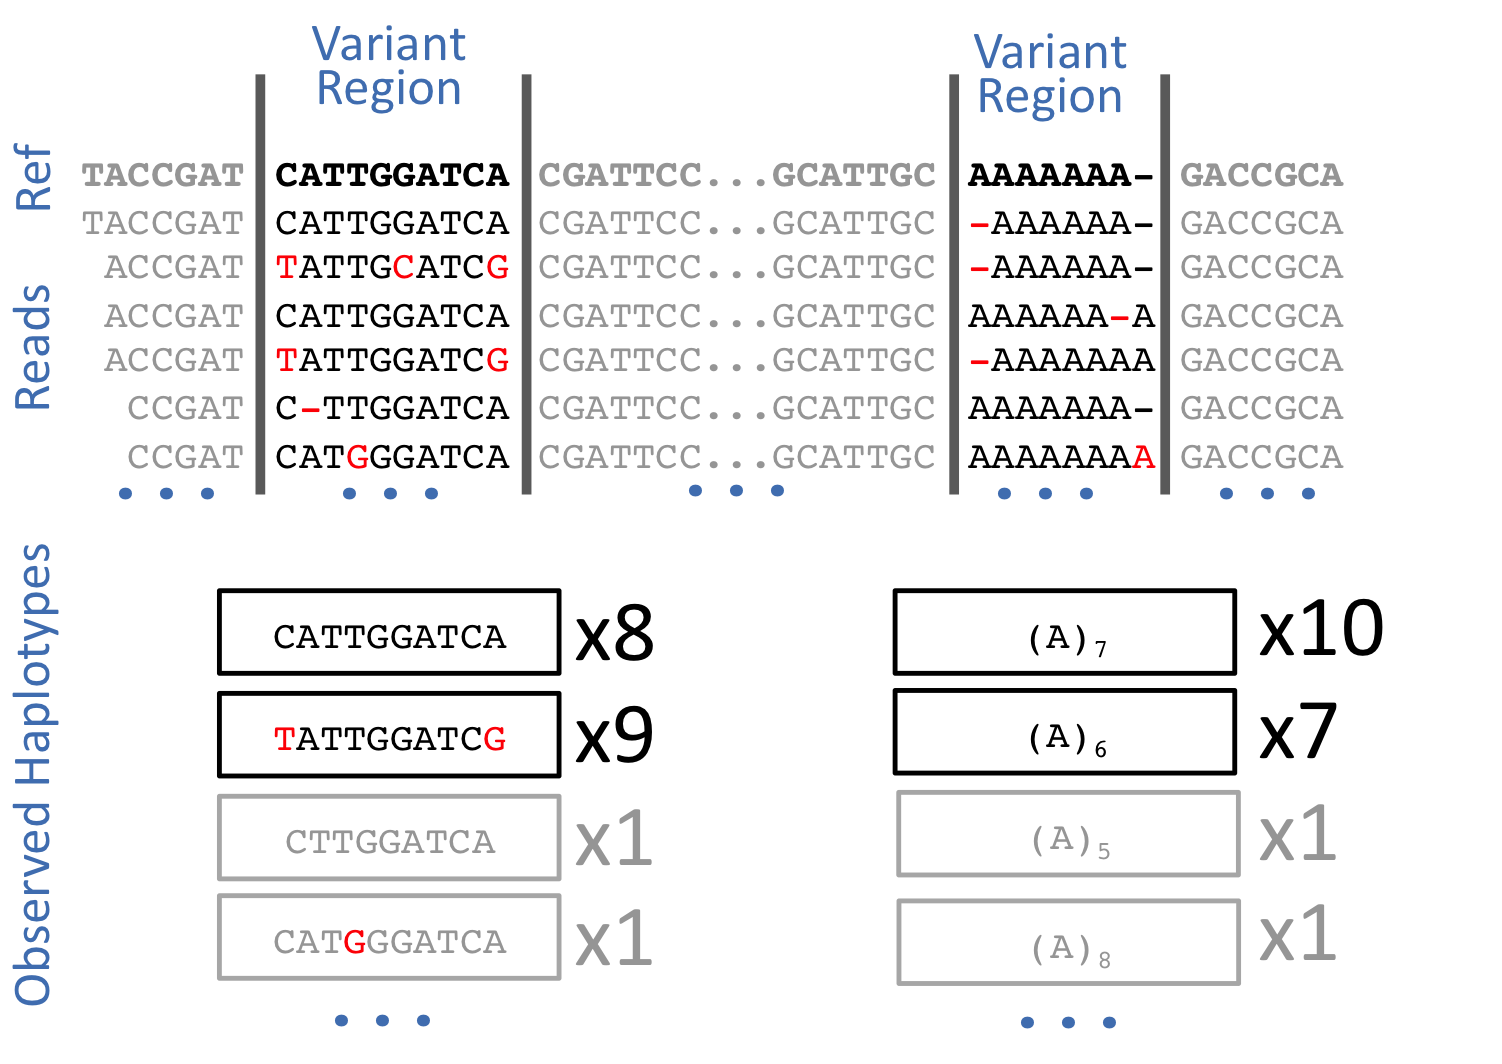 (credit ekg.github.io)

Even though Illumina is quite accurate, it’s not perfect.  Variant callers like freebayes try to figure out what’s a “real” variant from what’s an artifact/sequencing noise.

(Note this step takes about 10 minutes or so)

In [5]:
!freebayes -f /home/kwoyshn1/hg19_reference_genome/hg19.fa -b father.filtered.rmdup.bam mother.filtered.rmdup.bam proband.filtered.rmdup.bam > variants.vcf

## Step 7: Post-processing

Now we are working with a Variant Call Format (VCF) File:

The specification for this format is here: (https://samtools.github.io/hts-specs/VCFv4.2.pdf) 
It’s another tab delimited file, with header lines delineated by “##”, then columns describing the variant’s position and type, then columns per sample with the number of reads and/or information supporting the variant
Bcftools can be used to manipulate these tools, as can pysam (python) and other packages in different languages

The bcftools norm command is a tool used for normalizing Variant Call Format (VCF) files. It is part of the bcftools software package, which is commonly used in genomics analysis.

When working with genetic data, it is important to have standardized and consistent representations of genetic variants. VCF files contain information about genetic variations, such as single nucleotide polymorphisms (SNPs) or insertions/deletions (indels). However, due to various factors, such as sequencing errors or alternative representations of the same variant, VCF files can have redundant or inconsistent entries.

The bcftools norm command helps to address these issues by normalizing the VCF file. It performs several operations to ensure that the variants are represented in a standardized and simplified manner. Here are some of the tasks performed by bcftools norm:

Left-aligning variants: Variants may have different starting positions due to small differences in the reference genome used for alignment. bcftools norm adjusts the positions of variants to the leftmost position possible, improving consistency.

Normalizing indels: Indels can have multiple representations, such as insertions or deletions relative to the reference genome. bcftools norm normalizes indels to a standardized representation, making it easier to compare and analyze them.

Decomposing complex variants: Complex variants, such as multiple substitutions or overlapping indels, can be decomposed into simpler components. bcftools norm breaks down complex variants into their constituent parts, simplifying downstream analysis.

Removing redundant variants: In some cases, VCF files may contain redundant entries for the same variant. bcftools norm identifies and removes these redundant variants, reducing duplication and improving data quality.

By performing these normalization steps, bcftools norm helps to ensure that VCF files are consistent, standardized, and easier to work with in downstream analysis pipelines. It is an essential tool in genomics research and variant calling workflows.

In [28]:
!bcftools norm -Oz -f /home/kwoyshn1/hg19_reference_genome/hg19.fa -m -any variants.vcf -o normalized_variants.vcf.gz

Lines   total/split/joined/realigned/skipped:	36260/1758/0/3816/0


Next - we are going to try to process the normalized VCF file to identify the gene that is likely causing the disease.  We will use bcftools to filter to just autosomal recessive variants - variants which are heterozygous in the parents and homozygous in the proband.

First we'll index

In [29]:
!bcftools index normalized_variants.vcf.gz

Now we'll filter based on the samples - the order is proband (0), mother (1), father (2)

In [37]:
!bcftools view -i 'FMT/GT[0]="1/1" && FMT/GT[1]="0/1" && FMT/GT[2]="0/1"' normalized_variants.vcf.gz -o filtered_recessive.vcf


## Step 8: Download VCF file, interpret in OpenCravat
